In this demonstration, we consider the following 1-D Gaussian mixture density function:
$$
f(x) \propto 0.5 \exp \left( -\frac{(q-1)^2}{2 \times 0.35^2} \right) + 0.5 \exp \left( -\frac{(q+1)^2}{2 \times 0.35^2}\right),
$$

In [1]:
import sys
sys.path.append('../')
from hamilton_neural_network import (
    TrainTestData,
    LatentHamiltonianNeuralNetwork,
)
from hamilton_system import HamiltonianSystem
from pdf_models import IndepedentGaussians, OneDimGaussianMixtureDensity
import tensorflow as tf
import matplotlib.pyplot as plt
from no_u_turn.nuts import NoUTurnSampling
tf.random.set_seed(0)

2025-02-27 18:00:14.480050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740650414.496454  194664 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740650414.501322  194664 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 18:00:14.518345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.18.0


In [2]:
expU = OneDimGaussianMixtureDensity()
expK = IndepedentGaussians(tf.constant([0.0]), tf.constant([1.0]))
q0 = tf.constant([2.5])
p0 = tf.constant([0.0])
T = 20.0
leap_frog_per_unit = 20
num_samples =20
num_train = int(0.9 * num_samples * leap_frog_per_unit * T)

I0000 00:00:1740650416.404165  194664 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:2b:00.0, compute capability: 7.5


Generating samples...
Finished generating samples.


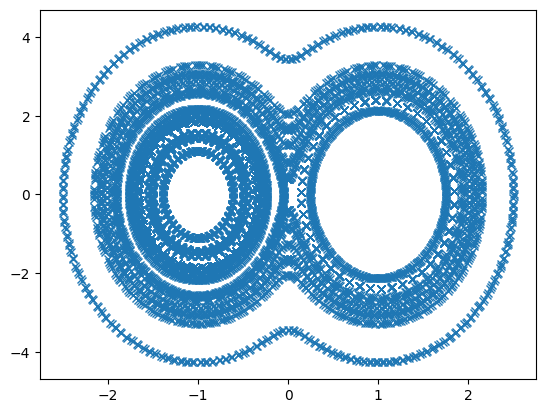

In [3]:
train_test_data = TrainTestData(
    num_samples, T, leap_frog_per_unit, q0, p0, expU, expK
)
samples = train_test_data()
tf.io.write_file("../exps/demo1_train_test_data.txt", tf.io.serialize_tensor(samples))
plt.plot(samples[:, 0], samples[:, 1], "x")
plt.show()

In [6]:
file = tf.io.read_file("../exps/demo1_train_test_data.txt")
train_test_data = tf.io.parse_tensor(file, out_type=tf.float32)
train_test_data = tf.random.shuffle(train_test_data)
train_data = train_test_data[:num_train, :]
test_data = train_test_data[num_train:, :]
lhnn = LatentHamiltonianNeuralNetwork(3, 16, 2)
lhnn.build(input_shape=(1, 2))
train_hist, test_hist = lhnn.train(10000, 1000, 4e-5, train_data, test_data, save_dir="../exps/demo1_lhnn.weights.h5", print_every=1000)

Training started...
Epoch 0: Train loss 24.855295181274414, Test loss 24.787137985229492.
Epoch 1000: Train loss 6.349114894866943, Test loss 6.7336297035217285.
Epoch 2000: Train loss 0.19924697279930115, Test loss 0.26204630732536316.
Epoch 3000: Train loss 0.02581856958568096, Test loss 0.02943355217576027.
Epoch 4000: Train loss 0.004102621227502823, Test loss 0.005688585806638002.
Epoch 5000: Train loss 0.0012620565248653293, Test loss 0.0019785023760050535.
Epoch 6000: Train loss 0.0006729011074639857, Test loss 0.001133818761445582.
Epoch 7000: Train loss 0.00043520276085473597, Test loss 0.0007380876340903342.
Epoch 8000: Train loss 0.0003060507297050208, Test loss 0.0005386572447605431.
Epoch 9000: Train loss 0.00022476460435427725, Test loss 0.00040450121741741896.
Training complete!


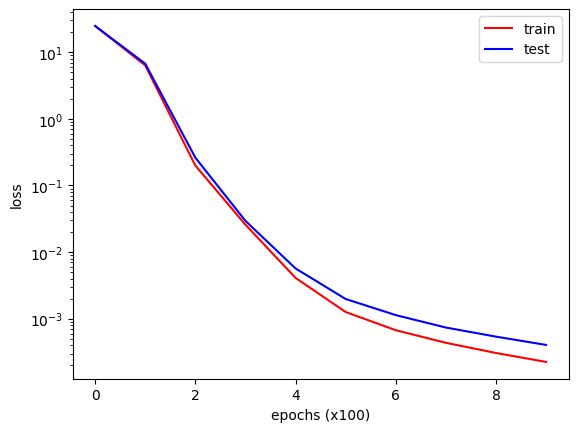

In [7]:
ax, fig = plt.subplots()
fig.plot(train_hist, label="train", color="red")
fig.plot(test_hist, label="test", color="blue")
fig.legend()
fig.set_yscale("log")
fig.set_xlabel("epochs (x100)")
fig.set_ylabel("loss")
plt.show()

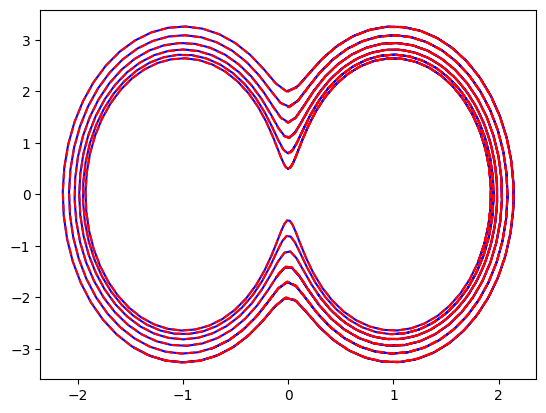

In [3]:
lhnn = LatentHamiltonianNeuralNetwork(3, 16, 2)
lhnn.build(input_shape=(1, 2))
lhnn.load_weights("../exps/demo1_lhnn.weights.h5")
q0 = tf.constant([0.0])
fig, ax = plt.subplots()
p_list = tf.linspace(0.5, 2.0, 6)
dt = 1.0 / 20
n_steps = 120
original_hamiltonian = HamiltonianSystem(expU, expK)

for i in range(6):
    p0 = tf.constant([p_list[i].numpy()])
    hist_original = original_hamiltonian.symplectic_integrate(q0, p0, dt, n_steps)
    hist_lhnn = lhnn.symplectic_integrate(q0, p0, dt, n_steps)
    ax.plot(
        hist_original[:, 0],
        hist_original[:, 1],
        label="Numerical gradients",
        color="blue",
    )
    ax.plot(
        hist_lhnn[:, 0],
        hist_lhnn[:, 1],
        color="red",
        label="HNNs",
        linestyle="--",
    )
plt.show()

Sample 0 of 5000
Sample 500 of 5000
Sample 1000 of 5000
Sample 1500 of 5000
Sample 2000 of 5000
Sample 2500 of 5000
Sample 3000 of 5000
Sample 3500 of 5000
Sample 4000 of 5000
Sample 4500 of 5000


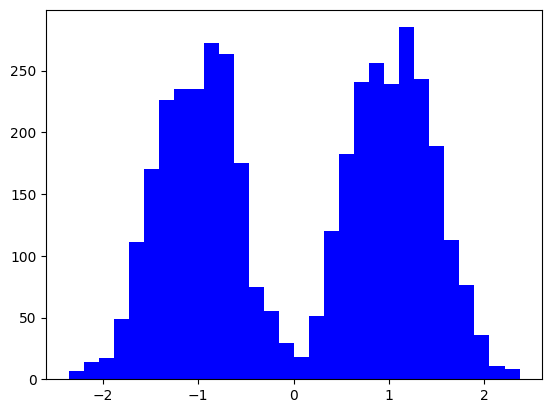

In [3]:
lhnn = LatentHamiltonianNeuralNetwork(3, 16, 2)
lhnn.build(input_shape=(1, 2))
lhnn.load_weights("../exps/demo1_lhnn.weights.h5")
q0 = tf.constant([0.0])
fig, ax = plt.subplots()
p_list = tf.linspace(0.5, 2.0, 6)
dt = 1.0 / 20
n_steps = 120
original_hamiltonian = HamiltonianSystem(expU, expK)
nuts = NoUTurnSampling(
    num_samples=5000,
    q0=q0,
    dt=0.05,
    lhnn=lhnn,
    Hamiltonian=original_hamiltonian,
    Delta_lf=10.0,
    Delta_lhnn=1000.0,
    num_lf_steps=20,
)
nuts(print_every=500)
q_hist = tf.concat(nuts.q_hist, axis=0)
plt.hist(q_hist.numpy()[1000:, 0].flatten(), bins=30, color="blue")
plt.show()